In [1]:
def compute_autocorrelation(x): #functie generica autocorelatie (determina periodicitatea semnlalului)
    result = np.correlate(x, x, mode='full') 
    return result[int(result.size/2):]

def peak_detection(sample, sampling_frequency, max_F0): #detectie maxime 
    local_max = [sample[0]] #maxime locale
    local_max_ind = [0]    #indicii maximelor locale
    indices = [0] #construieste lista
    
    min_peak_distance = sampling_frequency//max_F0 #distanta minima intre varfuri (impartire cu aproximare in jos)
    
    for i in range(1,len(sample)-1): #for de la 1 la nr. cadre-1
        if sample[i] > sample[i-1] and sample[i] > sample[i+1]: # maxim dintre vecini
            local_max_ind.append(i) #adauga incicele maximului la lista
            local_max.append(sample[i]) #adauga valoarea maximului

    i = 1
    while i < len(local_max): #while pana cand i ajunge la ultimul maxim local
        next_max = np.argmax(local_max[i:]) #argmax => maximul dintr-un array    
        if local_max_ind[i+next_max] - local_max_ind[i-1] > min_peak_distance:
            indices.append(local_max_ind[next_max+i])
        i = i+next_max+1
    
    return indices #returneaza lista indici

def _filter(this_frame): #filtrare trece jos
    cutoff = 499 #frecv de taiere
    # ordinul filtrului
    order = 5
    # frecvența Nyquist
    nyq = 0.5 * sample_rate
    # normalizăm frecvența de tăiere
    normal_cutoff = cutoff / nyq
    # calculăm coeficienții unui filtru Butterworth de tip trece-jos
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # filtrăm datele
    filtered_data = lfilter(b, a, this_frame)
    return filtered_data

do =  {
        "note": "Do",
        "freq": 262
    }
    
re = {
        "note": "Re",
        "freq": 294
    }
    
mi = {
        "note": "Mi",
        "freq": 330
    }
    
fa = {
        "note": "Fa",
        "freq": 349
    }
    
sol = {
        "note": "Sol",
        "freq": 392
    }
    
la =  {
        "note": "La",
        "freq": 440
    }
    
si = {
        "note": "Si",
        "freq": 494
    }

                
    

In [2]:
import pyaudio
import wave

def record(filename, _format, channels, sample_rate, chunk_size, rec_time): #functie inregistrare voce 
    
    #1. preluare esantioane
    if filename[len(filename)-3: len(filename)] != ".wav": #adauga extensia fisierului in cazul in care lipseste
        filename += ".wav"

    audio = pyaudio.PyAudio()

    # start Recording
    print("REC")
    stream = audio.open(format=_format, channels=channels,
                    rate=sample_rate, input=True,
                    frames_per_buffer=chunk_size)
    frames = []

    for i in range(0, int(sample_rate / chunk_size * rec_time)): #cat timp inregistram?
        data = stream.read(chunk_size)
        frames.append(data)

    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()
    print("done")

    #2. scriere in fisier 
    waveFile = wave.open(filename, 'wb')
    waveFile.setnchannels(channels)
    waveFile.setsampwidth(audio.get_sample_size(_format))
    waveFile.setframerate(sample_rate)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()
                            
#apelarea functiei record cu parametrii urmatori: nume fisier,format 16biti,stereo,frecventa esantionare 44100, 
#1024 esantioane,2 secunde inregistrare
record(filename="inregistrare", _format=pyaudio.paInt16, channels=2, sample_rate=44100, chunk_size=1024, rec_time=5)

path = "C:/Users/keler/a.wav" #locatia fisierului


wav_struct = wave.open(path, 'r') #deschide fisierul
wav_bytes = wav_struct.readframes(-1) #citire esantioane

import numpy as np
wav_data = np.frombuffer(wav_bytes, dtype="int16") #conversie la int16

sample_rate = wav_struct.getframerate() #aflare frecventa esantionare

wav_struct.close()  #inchidem fluxul de date



ModuleNotFoundError: No module named 'pyaudio'

Frecventa notei Si cantata de tine : 166 Hz
Frecventa notei Si cantata corect : 494 Hz


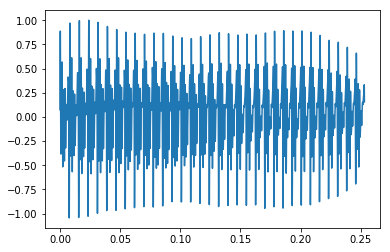

In [32]:
from scipy.signal import lfilter, butter

window = int(20*1e-3*sample_rate) #dimensiunea ferestrei de analiza (nr. de esantioane prelucrate odata)

frames = int(len(wav_data)/window) 
#aflare numar intreg de cadre(numar total esantioane/dimensiunea ferestrei)
#tratam ca si int pt ca python e dynamically typed (nu specifici tipul la declararea var)

for k in range(frames-1):
    this_frame = wav_data[k*window : (k+1)*window] #fereastra curenta 
    filtered_data = _filter(this_frame); #filtrare trece jos sub 499 Hz
    autocorrelation = compute_autocorrelation(filtered_data) #periodicitatea semnalului
    indices = peak_detection(autocorrelation, sample_rate, 499) #detectie varfuri
difs = [x-indices[i-1] for i,x in enumerate(indices)][1:] #diferenta intre indecsii returnati de functie

#determinăm media diferențelor
average_dist = np.mean(difs[:3])

#print(average_dist)

F0 = sample_rate/average_dist #frecventa fundamentala = rata de esantionare/distanta medie intre maxime

reference_note = si #selectam nota pe care dorim sa o cantam

import matplotlib.pyplot as pl
%matplotlib inline
time_axis = np.arange(0, len(wav_data))*1.00/sample_rate
wav_data = wav_data/abs(max(wav_data))
pl.plot(time_axis,wav_data)


print("Frecventa notei %s cantata de tine : %d Hz" %(reference_note["note"], F0))
print("Frecventa notei %s cantata corect : %d Hz" %(reference_note["note"], reference_note["freq"]))